In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import os

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define dataset paths
train_dir = "/content/drive/MyDrive/train"
test_dir = "/content/drive/MyDrive/test"

In [ ]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation split
)

In [ ]:
# No augmentation for validation and test data
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Found 2802 images belonging to 5 classes.
Found 700 images belonging to 5 classes.
Found 700 images belonging to 5 classes.


In [ ]:
# Load VGG16 as feature extractor
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pre-trained layers

In [ ]:
# Build classifier (MLFFNN)
model = Sequential([
    base_model,
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    BatchNormalization(),
    Dense(train_generator.num_classes, activation='softmax')
])


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model with the Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can specify the learning rate here (default is 0.001)
    loss='categorical_crossentropy',  # For multi-class classification problems
    metrics=['accuracy']
)


✅ Showing Sample Images Before Training...


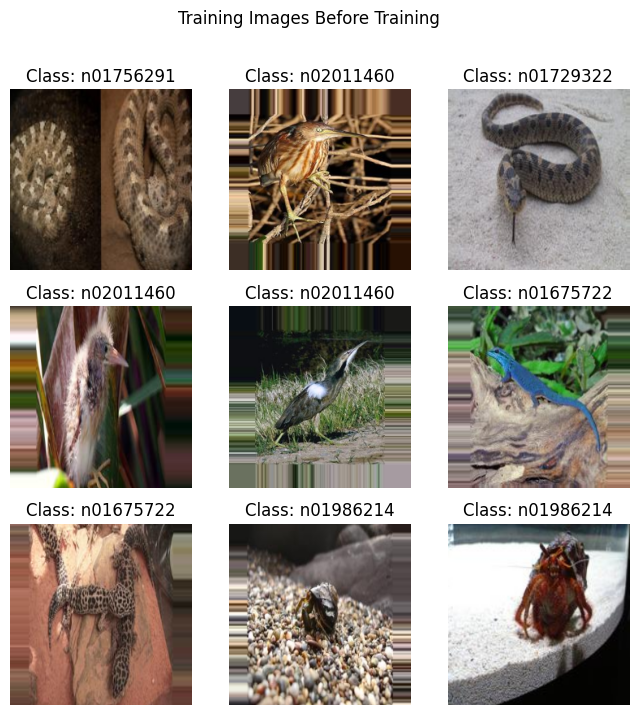

In [ ]:
# Function to show images during training
def show_images(generator, title, num_images=9):
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        img = images[i]
        label = class_names[np.argmax(labels[i])]
        ax.imshow(img)
        ax.set_title(f"Class: {label}")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

print("✅ Showing Sample Images Before Training...")
show_images(train_generator, "Training Images Before Training")

In [ ]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
    callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: show_images(train_generator, f"Training Images - Epoch {epoch+1}"))]
)


Epoch 1/10
 44/176 ━━━━━━━━━━━━━━━━━━━━ 22:18 10s/step - accuracy: 0.3586 - loss: 1.6739

KeyboardInterrupt: 

In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {accuracy * 100:.2f}%")

44/44 ━━━━━━━━━━━━━━━━━━━━ 441s 10s/step - accuracy: 0.7693 - loss: 0.6064
✅ Test Accuracy: 74.57%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_images(model, generator, class_names, num_images=5):
    collected = {}

    for _ in range(len(generator)):  # Loop through generator
        images, labels = next(generator)
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        for i in range(len(images)):
            true_label = true_classes[i]
            if true_label not in collected:
                collected[true_label] = (images[i], true_label, predicted_classes[i])
                if len(collected) >= num_images:
                    break
        if len(collected) >= num_images:
            break

    # Plot the collected samples
    fig, axes = plt.subplots(1, len(collected), figsize=(18, 4))
    for i, (cls, (img, true_label, pred_label)) in enumerate(collected.items()):
        ax = axes[i]
        ax.imshow(img)
        ax.set_title(
            f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
            color="green" if true_label == pred_label else "red",
            fontsize=11
        )
        ax.axis("off")
    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

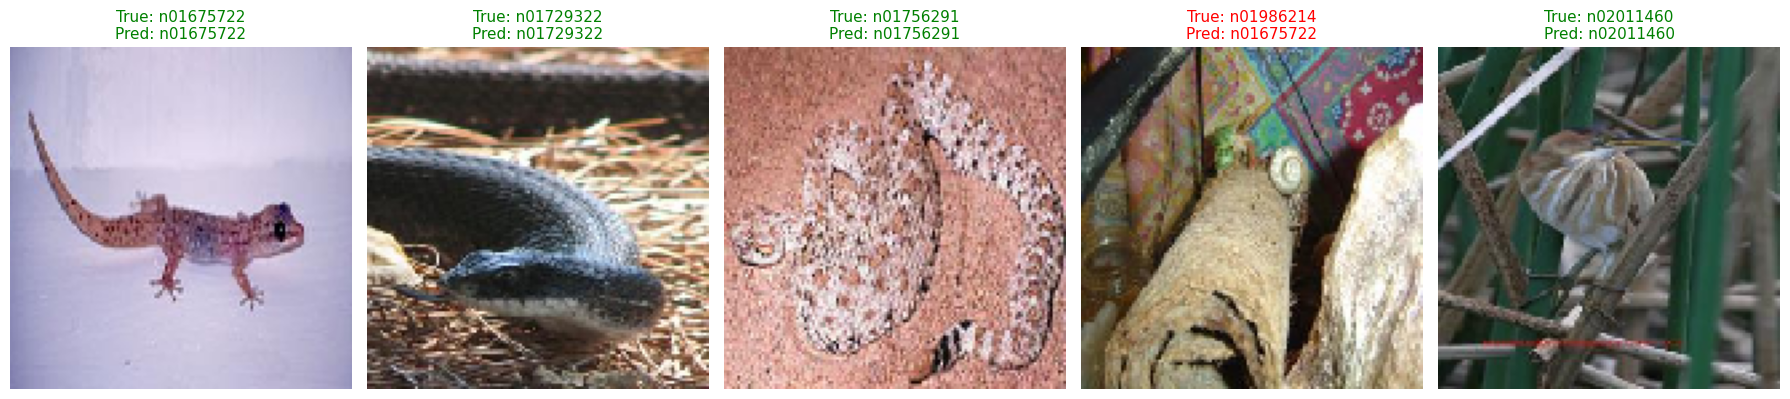

In [ ]:
class_names = list(train_generator.class_indices.keys())
predict_images(model, test_generator, class_names, num_images=5)  # or num_images=10

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s

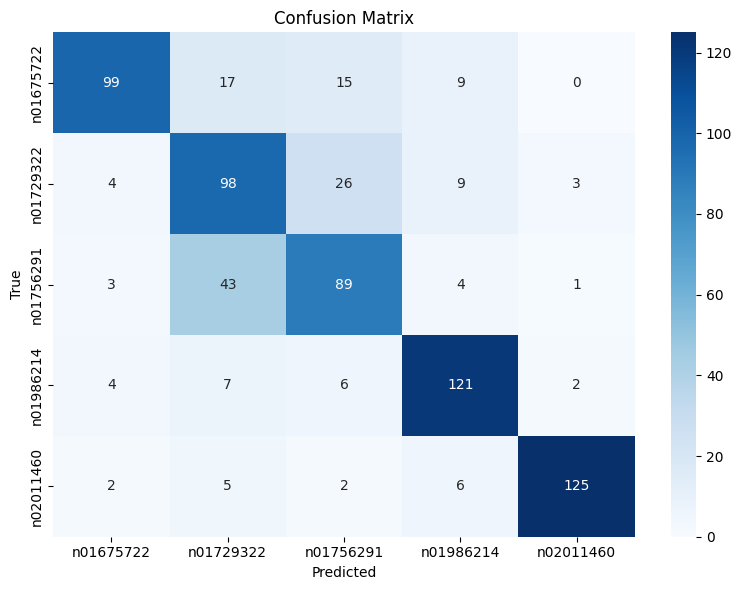

📊 Classification Report:

              precision    recall  f1-score   support

   n01675722       0.88      0.71      0.79       140
   n01729322       0.58      0.70      0.63       140
   n01756291       0.64      0.64      0.64       140
   n01986214       0.81      0.86      0.84       140
   n02011460       0.95      0.89      0.92       140

    accuracy                           0.76       700
   macro avg       0.77      0.76      0.76       700
weighted avg       0.77      0.76      0.76       700



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true and predicted labels for the entire test set
y_true = []
y_pred = []

# Reset test_generator and get predictions
test_generator.reset()

for _ in range(len(test_generator)):
    images, labels = next(test_generator)
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Class names
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Optional: Classification report
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
